# JSC Assignment 3: Natural Language Processing

## Detective Karl Nurmeots and Samuel Vedrik


# Introduction 

Enron was an American Energy company which was founded in 1985 by Kenneth Lay. In 2001 it was revealed that Enron had been performing systematic accounting fraud, which lead to multiple lawsuits and indictments. As a result of this, Enron filed for bankruptcy in October 2001.

This assignment uses a dataset of emails sent and received by the top executives of Enron from 1999 to 2002.

For this assignment we are assuming the roles of investigators who have suspicions about Enron's doings, and we want to obtain a better understanding of what, if any, wrongdoing has occurred. While our suspicions have merit (and, of course, we have knowledge of wrongdoing in retrospect), it is important to treat everyone involved as innocent until proven guilty.

### Value Added

This dataset is very limited in terms of what evidence of wrongdoing it can provide: it is a small fraction of the documents and evidence that would be required to accuse anyone of fraud. As such, we hope to provide insights about Enron which would help further probing investigations focus on certain specifics. We believe that this dataset is a great way to understand the network dynamics of Enron. By understanding the topics of emails we can hopefully detect outlying emails or persons to further investigate. We will also analyze the topics of emails as they change through time to better understand the behaviour of Enron's top executives as this alleged fraud was committed.

### Success Measures

Measuring the success of this project is very difficult. The concepts of revealing the truth and achieving justice are very abstract. Fines and indictments are concrete examples of these, but the manner of punishment is always restricted by the evidence investigators are able to gather. Furthermore, it is possible that charges are produced inadequately with respect to the evidence available: it is even possible that innocent people are charged as guilty of wrongdoing.

A more relaxed way of measuring success is by understanding how this analysis allowed investigators to hone in on the case. If this project enables investigators to reveal further evidence, it speaks to the value and success of the analysis.

The value of this project could be quantified by evaluating the net benefit to society once the case is concluded. That is, how much benefit did the investigation bring to society - measured in fines paid, evaded taxes returned, dishonest people removed from positions of power, etc. - versus how much cost to society did it incur - man-hours spent on the case, number of jobs lost, damage to reputation, etc.

For measuring the success of our models we will primarily rely on our own intuition. Natural language models are very difficult to evaluate, and we do not have a clear target to set for our models. By building different models which focus on different aspects of the data, a good indication of the success of our models is if the story they are telling is consistent among the models.

# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
import string

!pip install -q gensim
import gensim
from gensim import corpora, models

from collections import Counter
import gensim,logging, warnings
warnings.filterwarnings("ignore")
!pip install -q pyLDAvis
from pyLDAvis import gensim
from gensim.models import ldamodel
import pyLDAvis
import pyLDAvis.sklearn
from pyLDAvis import sklearn as sklearn_lda

!pip install -q holoviews
import holoviews as hv

import matplotlib.pyplot as plt
%env HV_DOC_HTML=true

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 1.7MB 5.6MB/s 


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HTTPHeaders(collections.MutableMapping):


env: HV_DOC_HTML=true


In [2]:
plt.rcParams["figure.figsize"] = (13, 7)
plt.style.use("seaborn")

In [3]:
!wget https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/enron_top_exe_mails.csv


--2021-03-11 00:06:48--  https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/enron_top_exe_mails.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7935976 (7.6M) [text/plain]
Saving to: ‘enron_top_exe_mails.csv’

enron_top_exe_mails 100%[===================>]   7.57M  27.0MB/s    in 0.3s    

2021-03-11 00:06:49 (27.0 MB/s) - ‘enron_top_exe_mails.csv’ saved [7935976/7935976]



# Data Cleaning

In [4]:
enron = pd.read_csv("enron_top_exe_mails.csv")
df = pd.DataFrame(enron)

A glimpse at the data in its raw form:

In [5]:
df.head()

Unnamed: 0  ...                   subject
0           0  ...    Performance Management
1           1  ...    Performance Management
2           2  ...   Re: dinner next tuesday
3           3  ...   RE: dinner next tuesday
4           4  ...  RE: Porlock Vale in 2000

[5 rows x 8 columns]

In [6]:
df = df.drop("Unnamed: 0", axis=1)

## Preprocessing

In [7]:
# text preprocessing 

df["text"] = df['text'].apply(lambda x: x.strip('[]')) 
df["text"] = df['text'].apply(lambda x: x.strip("'',"))
df["text"] = df['text'].apply(lambda x: x.strip(", '',"))


# remove "From" from sender mail ids
def remove_from(text): 
    mail = re.sub(r'From:', '', text)
    return mail

# remove "To" from recipient mail ids
def remove_to(text): 
    mail = re.sub(r'To:', '', text)
    return mail

#remove unnecessary line breakers 
def remove_obj(text): 
    mail = re.sub('\'', '', text)
    return mail

#defin a function to remove punctuation from text
def remove_punct(text):
    punct = "".join([i for i in text if i not in string.punctuation])
    return punct

# remove numbers from mail body 
def remove_numbers(text): 
    mail = re.sub(r"\d+", "", text)
    return mail



# applying all defined functions 
df['senders'] = df['senders'].apply(lambda x : remove_from(x))

df['recipients'] = df['recipients'].apply(lambda x : remove_to(x))

df['text'] = df['text'].apply(lambda x : remove_obj(x))

df['text'] = df['text'].apply(lambda x : remove_punct(x)) 

df['text'] = df['text'].apply(lambda x : remove_numbers(x))


In [8]:
# Removing security footer, occurs in 58 emails
# footer is how all of these footers start after previous cleaning
footer = 'PrivilegedConfidential Information'
df.text = df.text.str.split(footer).str[0]

In [9]:
df["uncleaned_text"] = df["text"]

## Stopwords Removal

In addition to the typical stopwords, we will remove words that are common in emails.

In [10]:
additional_stop = ['hello', 'thank', 'thanks', 'regards', 'would', 'please', 'email', 'could',
                 'attached', "enron", "many", "us",
                 "let", "know", "mr", "dear"]

def get_stop_words():
    stop = stopwords.words('english')
    
    # Add these weird X tags when you notice them!
    stop.append("xfrom")
    stop.append("xto")
    stop.append("xcc")
    stop.append("xbcc")
    stop.append("xfolder")
    stop.append("xorigin")
    stop.append("xfilename")

    # Stuff common in emails
    stop.extend(additional_stop)
    
    return stop



In [11]:
# Remove stop words
stop = get_stop_words()
df['text'] = df['text'].apply(lambda words: ' '.join(
    [word.lower() for word in words.split() if word.lower() not in stop]))

In [12]:
# creating dataframe only for those mails received by the co-founder of Enron, Kenneth Lay
cf_df = df[df["recipients"].str.contains("kenneth.lay@enron.com")]

In [13]:
df_network = df.copy()
df_network["list_of_recipients"] = df_network["recipients"].apply(lambda x: x.strip().split(", "))
df_network["senders"] = df_network["senders"].apply(lambda x: x.strip())
df_network = df_network.explode("list_of_recipients").reset_index(drop=True)
df_network["list_of_recipients"] = df_network["list_of_recipients"].apply(lambda x: x.strip("<>"))
df_network = df_network[~df_network["list_of_recipients"].isin(["email", "pr"])]

# Exploratory Data Analysis


## Overview

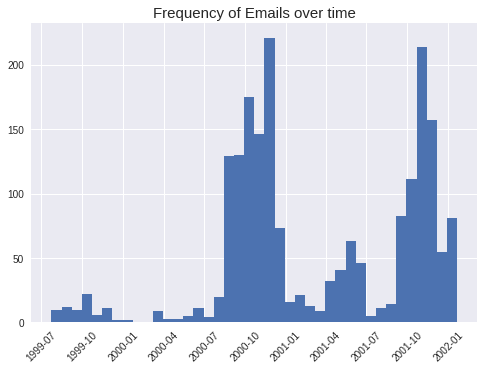

In [14]:
dates = pd.to_datetime(df["date"])
dates = dates[dates.apply(lambda x: x.year > 1990)]
dates.hist(bins=40)
plt.xticks(rotation=45)
plt.title("Frequency of Emails over time", fontsize=15)
plt.show()

We can see from the distribution of emails that most emails are sent in the 3rd quarters of the year 2000 and 2001. This can be attributed to end-of-year reports, or it may be evidence of malicous data manipulation.

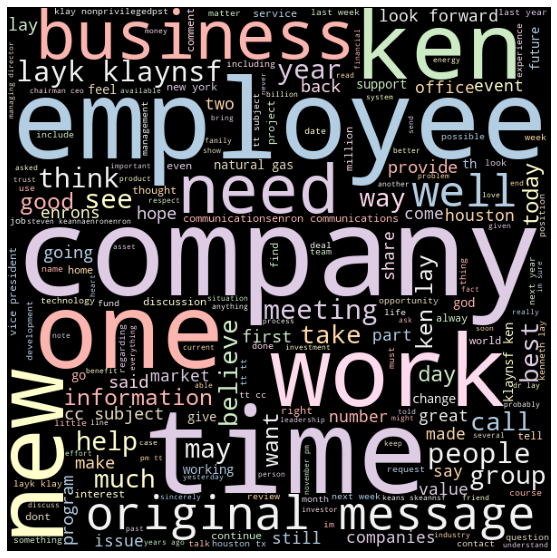

In [15]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 10))
plt.imshow(WordCloud(width=600, height=600, colormap="Pastel1").generate(" ".join(df["text"].values)))
plt.axis("off")
plt.show()

Note the many different ways to refer to Kenneth lay: ken, lay, layk, klaynsf, etc. This example speaks to the fact that regardless of how thorough our cleaning process is, the emails will still contain words that may affect our analysis in undesireable ways.

During investigations, we noticed that there are quite a few emails that are religious in nature. We should take a look at how many emails contain the word "god". 

In [16]:
god_filter = df["text"].str.contains("\sgod\s") # sounds badass
god_filter.sum()

<input>:1: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \s
<ipython-input-16-bbf184719a4b>:1: DeprecationWarning: invalid escape sequence \s
  god_filter = df["text"].str.contains("\sgod\s") # sounds badass


59

In [17]:
df[god_filter].iloc[3, -1]

'In quietness and confidence is your strength    Isaiah   tA missionary in India was kneeling at his bed praying one night when a giant python snake uncoiled itself from the rafters and wrapped itself around his body  The python which is not uncommon in India kills its victim by squeezing it to death  The missionary told how a Bible verse immediately came to mind as the meandering serpent enveloped his body  In quietness and confidence is your strength  And suddenly he was filled with the calm assurance that God was in control  He remained perfectly still praying and meditating like he never had before  tHad he struggled hesitated or tensed up the coils of the mighty creature would have constricted and crushed him  Instead he waited prayed stayed calm and didnt move a muscle  Slowly the snake uncoiled itself and retreated back to the rafters  tMost of us admire that kind of quiet COURAGE  I dont believe there is a value that is more recognizable and admirable in a human life than coura

While this finding doesn't appear to be significant in relation to our task, it is a strange pattern to observe in a corporate email dataset.

## Emails

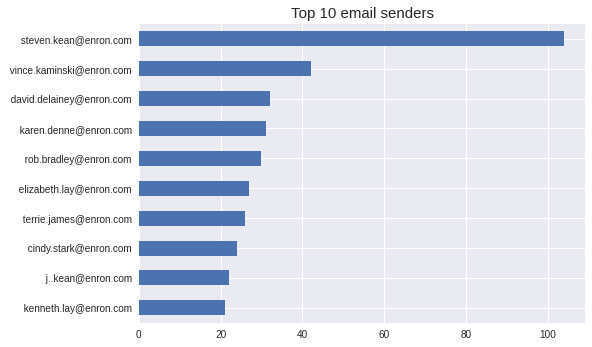

In [18]:
df["senders"].value_counts(ascending=True).iloc[-10:].plot.barh()
plt.title("Top 10 email senders", fontsize=15)
plt.show()

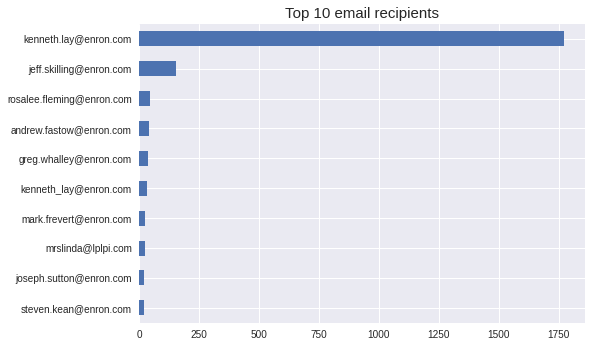

In [19]:
df_network["list_of_recipients"].value_counts(ascending=True).iloc[-10:].plot.barh()
plt.title("Top 10 email recipients", fontsize=15)
plt.show()

We note that there are two different Kenneth Lay emails: one with a dot and one with an underscore.

In [20]:
df_network[df_network["list_of_recipients"] == "kenneth_lay@enron.com"].loc[1462, "uncleaned_text"]

'Uncle Ken        I just wanted to drop an  email letting you know that we are praying for you  Everything will work  out and Enron will be back on its feet ready to run again  Good Luck with  everything Sincerely Jim'

In [21]:
print("Domains of email addresses sending emails to kenneth_lay@enron.com")
klay_emails = df_network[df_network["list_of_recipients"] == "kenneth_lay@enron.com"]
klay_emails["senders"].apply(lambda x: x.split("@")[1]).value_counts()

Domains of email addresses sending emails to kenneth_lay@enron.com


lplpi.com             13
hotmail.com            3
kainon.com             3
mobilestar.com         3
yahoo.com              2
netscape.net           2
layfam.com             2
gatepoint.net          1
bankone.com            1
inventx.com            1
home.com               1
processrequest.com     1
Name: senders, dtype: int64

None of the emails sent to kenneth_lay@enron.com have the "enron.com" domain, which suggests that this is the CEO's email for private use.

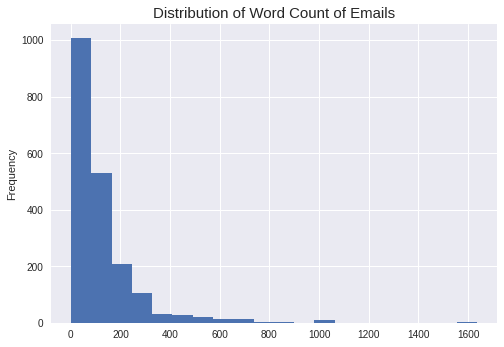

In [22]:
df["text"].str.split(" ").apply(lambda x: len(x)).plot.hist(bins=20)
plt.title("Distribution of Word Count of Emails", fontsize=15)
plt.show()

We could restrict our analysis to emails longer than a certain minimum length so our models analyze emails with "more" content, but this would make us miss out on most of the data, which is why we will refrain from doing so.

# Brainstorming

### Potential Additional Sources of Data

A much more complete picture of the case could be achieved by combining this dataset with Enron's stock information, and various other financial and otherwise relevant documents from Enron. Furthermore, the organizations investigation Enron definitely have collections of documents that would complement this dataset very well.

Of course, these executives of Enron did definitely not communicate solely using emails. Obtaining the call and SMS records of the people involved would give a much clearer picture of how these people communicated.

Ultimately, it is fairly certain that the people responsible for the wrongdoing did not directly discuss their fraudulent doings in these emails. It is very likely that most of these discussions were held in person behind closed doors, so having an FBI edition fly on the wall observing the suspects could prove to be very fruitful.

### All Possible Factors

Our models have access to only a small fraction of the information that actually affects their performance. The contents of the emails would definitely be affected by the executives' knowledge of a potential or ongoing investigation into their doings. Many emails might be simple ones to set up meetings or calls, so the emails themselves provide very little insight into the interaction. The true content of the emails is also likely bundled up with footers, security disclaimers and quips from previous emails in a chain, so it is very difficult to extract the actual message that was supposed to be conveyed.

It is also possible that the people involved have destroyed evidence by deleting emails, or even fabricated evidence by sending artificial emails to hide their wrongdoing.

# Modelling


### Model "Roundtable"

Rather than the usual model staircase, we propose a model roundtable. Our models will focus on different aspects of the data, and as such they do not necessarily build on one another. Instead, we hope that they complement each other by describing different sides of the same story and paint a picture of the entire situation.

**Model 0**: Top $K$ words over time

**Model 1**: Network analysis

**Model 2**: Clustering of emails using TF-IDF

**Model 3**: Latent Dirichlet allocation

**Model 4**: Dynamic Topic Modeling - LDA over time




## Top K words over time

We will group the dataset by month, and find the top K words over time. We define a "top word" as words that have the highest TF-IDF score in that month. We chose to use the TF-IDF score as it reflects the importance of every word in a more meaningful way.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

dates = pd.to_datetime(df["date"])
df_top_k = df.copy()
df_top_k["stamp"] = dates.apply(lambda x: f"{x.year}, {x.month}")
df_top_k["text"] = df_top_k["text"].str.replace(r"\w+enromcom", "")
# df_top_k = df_top_k.drop_duplicates("text")

TOP_K = 10

# cv = CountVectorizer()
cv = TfidfVectorizer()
word_counts = cv.fit_transform(df_top_k["text"]).toarray()
complete_counts = word_counts.sum(axis=0)
id_to_word = {id_: word for word, id_ in cv.vocabulary_.items()}

time_to_top_k = {}

for stamp in df_top_k["stamp"].unique():
  counts = word_counts[df_top_k["stamp"] == stamp, :].sum(axis=0)
  # counts = counts / complete_counts
  time_to_top_k[stamp] = [id_to_word[id_] for id_
                          in counts.argsort()[-10:]]

In [ ]:
# Hacky way to sort the column order. 
pd.DataFrame(time_to_top_k).T.sort_index().iloc[1:].T

1999, 10     1999, 11  ...           2001, 9     2002, 1
0         tcw         week  ...               new       login
1    equities         meet  ...              call     january
2  presenters      hunting  ...         employees         aol
3        kean    confirmed  ...  nonprivilegedpst         may
4     cynthia         fund  ...               ken      report
5      agenda       resume  ...              like     expense
6        lora  suggestions  ...              work       click
7        fund       krista  ...              klay  commentary
8    sandherr        kisch  ...         september   hyperlink
9        memo       carson  ...           houston      kudlow

[10 rows x 30 columns]

The table above shows the top K words for each month, with word 9 having the highest TF-IDF score.

An interesting insight is the prelevance of "blackstone" in May 2000. A quick google search ("blackstone 2000 enron") leads to this [article](https://archive.fortune.com/magazines/fortune/fortune_archive/2003/06/09/343947/index.htm). Further investigation into the relationship between Blackstone and Enron should be conducted.

Another interesting find is that the word "god" is important in the month following the unravelling of the Enron Scandal.

We also note that "california" is common in December, 2000 and May, 2001. We discuss this further in the TF-IDF clustering model, however it is good that both our models identified these key words. 

## Network Analysis

To perform our network analysis, we will build a chord diagram with people who have both received and sent emails. Within that set of people, we remove people who have not sent or received any emails from within that group. This way, we have a "clique" of executives / important employees that communicate with one another. 

In [ ]:
network_matrix = pd.crosstab(df_network["senders"], df_network["list_of_recipients"])
both = set(network_matrix.index).intersection(set(network_matrix.columns))
both = sorted(list(both))
both.remove("ken.rice@enron.com") # No outgoing/incoming emails
network_matrix = network_matrix[both].loc[both]
network_matrix.columns = network_matrix.columns.tolist()

In [ ]:
df_network_mat = pd.melt(network_matrix.reset_index(), id_vars=["senders"], 
                         value_vars=network_matrix.columns)

df_network_mat = df_network_mat.rename(columns={"senders": "source", 
                               "variable": "target"})

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
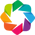

:Chord   [source,target]   (value)

In [ ]:
hv.extension("bokeh")
hv.output(size=300)
people = hv.Dataset(pd.DataFrame(both, columns=["email"]))

chord = hv.Chord((df_network_mat, people))
chord.opts(
    hv.opts.Chord(cmap="Category20c", node_color=hv.dim("email").str(), 
                  labels="email", edge_cmap = "Category20c", 
                  edge_color=hv.dim("source").str(), 
                  title="Emails between people",
                  )
)
chord

The chord diagram shows our initial discovery that a majority of emails are received by Kenneth Lay. This can be seen due to Kenneth Lay's "inbox" being full of different colors, indicating that many different people are sending him emails rather than him sending many different people emails. 

We also note that there are people who send a large amount of emails to Ken, such as Steve Kean and Rob Bradley. 

From the chord diagram above, we also observe that some ArthurAndersen emails are present - Arthur Andersen was Enron's audit company. It is interesting to note that unlike nearly everyone else in the diagram, email addresses with the ArthurAndersen domain virtually never send emails to Kenneth Lay. Since we have suspicions that Enron is committing financial fraud, understanding who the Arthur Andersen people communicate with in Enron could be vital to unraveling this scandal.

## Clustering with TF-IDF 

We hope to capture some patterns in the emails that can help bin them into different clusters. Our model performs three steps: 

* Create a TF-IDF vector for each document.
* Run PCA that keep 90% of the variance to reduce the number of dimensions. 
* Perform clustering with KMeans.

During our experimentation phase, we noticed that the inertia decreases linearly as we increase K. To avoid having a high number of clusters, we decided to use K = 15 clusters. 

However, we realized that it is difficult to create non-overlapping clusters. If we assume that each cluster is similar to a "topic" in LDA, then we are failing to account for a document being a combination of such latent topics. 

However, clustering can help us identify documents that are "out of the norm". We explore this concept more below.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

K = 15

In [24]:
tfidf = TfidfVectorizer(stop_words=stop)
tfidf_transformed = tfidf.fit_transform(df["text"])
pca = PCA(n_components=0.9)
tfidf_reduced = pca.fit_transform(tfidf_transformed.toarray())

In [25]:
clusterer = KMeans(n_clusters=K, random_state=42) #random state 42 original
clusters = clusterer.fit_predict(tfidf_reduced)
print(f"Silhouette score: {silhouette_score(tfidf_reduced, clusters)}")

Silhouette score: 0.04319486159551124


The silhouette score determines how good the clustering is. A score of -1 indicates wrong clusters, a score of 0 indicates many overlapping clusters, and a score of 1 indicates the best possible clustering. 

Since we have a score close to 0, we can assume that most emails are not too distinct from one another.

In [26]:
id_to_word = {id_: word for word, id_ in tfidf.vocabulary_.items()}
def get_words(vec):
  return [id_to_word[id_] for id_ in vec]

In [27]:
cluster_centers = pca.inverse_transform(clusterer.cluster_centers_)
cluster_centers_words = [get_words(vec) for vec in cluster_centers.argsort(axis=1)[:, -10:]]

In [28]:
print("Cluster Centers")
for i, cluster_center in enumerate(cluster_centers_words):
  print(f"Cluster {i}: {', '.join(cluster_center)}")

Cluster Centers
Cluster 0: kalen, gary, ginger, hamels, communications, pm, steven, terrie, charts, tt
Cluster 1: sandherr, survive, greeting, cisco, ipoemaildoc, shape, recover, steve, per, discussion
Cluster 2: confirmation, crenshaw, meet, tom, meeting, julian, vince, paul, shirley, london
Cluster 3: best, work, energy, business, employees, houston, time, lay, ken, company
Cluster 4: ken, sec, klaynsf, mark, report, call, pm, draft, jeff, meeting
Cluster 5: andersen, contact, confidentiality, jameswpetriejrusarthurandersencom, footer, houston, vince, allan, symposium, meet
Cluster 6: pdt, postmanncubecom, wandancubecom, raa, id, received, smtp, sfinkknowledgeucom, tue, sep
Cluster 7: sending, rice, vkaminsnsf, kaminskiv, forum, vkaminsenroncom, prof, kaminski, ikenberry, vince
Cluster 8: users, paste, subscriber, browser, login, kudlowcom, httpwwwkudlowcommembersloginasptocontentcontentid, commentary, kudlow, hyperlink
Cluster 9: summary, layk, memo, chairman, gas, media, event, mee

We note that cluster 14 seems to include "personal" emails, as it has terms not as commonly seen in business such as "god", "lord" and "love". We take a look at an example email from cluster 14:

In [47]:
df.iloc[920]["uncleaned_text"]

'Dear Ken and Linda I just want you to know William and I have been praying for you  I know yo ur hearts so I dont look at the circumstances and neither does God  It do esnt depend on the circumstances the strength of your arm or your voice   I hope you find this encouraging and uplifting  I wanted to share some verses with you both and some things that Oswald Cha mbers says in his book His Utmost for His Highest  My eager desire and ho pe being that I may never feel ashamed but that now as ever I may do honou r to Christ in my own person by fearless courage Phil   We shall all feel ashamed if we do not yield to Jesus on the point He aske d us to yield to Him  To get there is a question of will not of debate no r of reasoning but a surrender of will an absolute and irrevocable surren der on that point  An overweaning consideration for ourselves is the thin g that keeps us from that decison though we put it that we are considering  others  When we consider what it will cost others if we

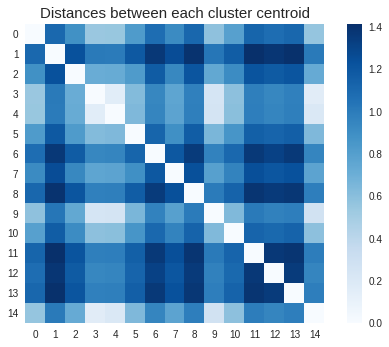

In [29]:
cluster_centers_raw = clusterer.cluster_centers_
cluster_dists = np.zeros((K, K))
for k in range(K):
  cluster_dists[k, :] = np.linalg.norm(
      cluster_centers_raw - cluster_centers_raw[k, :], axis=1)
  
plt.imshow(cluster_dists, "Blues")
plt.colorbar()
plt.title("Distances between each cluster centroid", fontsize=15)
plt.xticks(np.arange(K)), plt.yticks(np.arange(K))
plt.grid(b=None)
plt.show()

The graph above depicts the distances between each cluster centroid. Darker blue colors represent higher distances, and lighter colors represent smaller distances. We note that the clusters 3, 4, 9 and 10 are quite close to one another. This may indicate that the clusters are not too different from one another, and is in fact a "mega cluster".

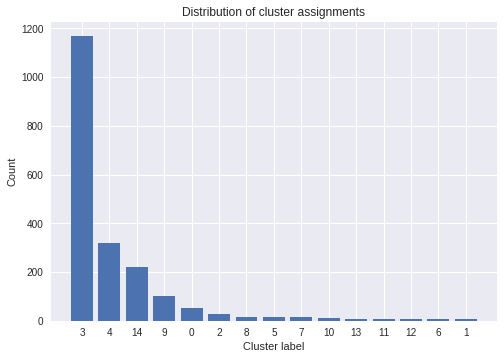

In [30]:
cluster_bins = pd.Series(clusters).value_counts()
plt.bar(cluster_bins.index.astype("str"), cluster_bins.values)
plt.title("Distribution of cluster assignments")
plt.xlabel("Cluster label"), plt.ylabel("Count")
plt.show()

The graph above shows the distribution of cluster assignments. We see that a majority of emails are classified into clusters 3 and 4. However, based on the plot above, we know that clusters 3 and 4 are close to one another, and thus we can assume that emails in clusters 3 and 4 are similar.

In [31]:
print("Average distances between points and cluster centroids:")
for i in range(K):
  dists = np.linalg.norm(tfidf_reduced - clusterer.cluster_centers_[i, :], axis=1)
  print(f"Cluster {i}: {dists[clusters == i].mean()}")

Average distances between points and cluster centroids:
Cluster 0: 0.8197853773427287
Cluster 1: 1.2595924416616083e-15
Cluster 2: 0.6497049461536908
Cluster 3: 0.9141050501835942
Cluster 4: 0.9691600723055143
Cluster 5: 0.7530208786902965
Cluster 6: 0.17160656157360943
Cluster 7: 0.603081844166684
Cluster 8: 0.09635272527219127
Cluster 9: 0.9498232709609423
Cluster 10: 0.7708353030302675
Cluster 11: 0.049159030598518186
Cluster 12: 0.20712566090386939
Cluster 13: 0.04310787819417472
Cluster 14: 0.9325792590914004


We note that the average cluster distances are very small for clusters will little assignments. Upon further investigation, the clusters with close to 0 average distance are clusters with a single email. (Different observations with the same email body).

In [32]:
cluster_1_id = np.where(clusters == 1)[0][0]
df.iloc[cluster_1_id]["uncleaned_text"]

'Per your discussion with Steve'

Investigating one such email does not produce any interesting insights.

Cluster 13 might be worth investigating, as it has some interesting key words. 

In [33]:
np.where(clusters == 13)[0]

array([  78,   80,  191,  219,  243,  281,  283,  310, 1151])

In [34]:
df.iloc[78]["uncleaned_text"] # The rest are similar copies of this email.

'Thank you again for attending last Thursdays meeting with Ken Lay  As a  followup to the meeting Im attaching a letter that outlines the fivepoint  solution Ken discussed  The governor and legislators need to hear from  Californias business leaders about a comprehensive solution that addresses  the short and longterm problems of Californias energy crisis  Please sign  this letter and send it to the following key legislators  and to any  legislators with whom you have a good relationship  Governor Gray Davis  Assembly Speaker Robert Hertzberg  Senate President Pro Tem John Burton  Assembly Speaker Pro Tem Fred Keeley  Assembly Republican Leader Dave Cox  Senator Debra Bowen  Please send me or Ken Lay a copy of the letter and keep us updated on any  feedback you receive from the governor and legislators  Thank you for your  assistance in helping advance a solution to Californias energy crisis  If  you have any questions or need additional information please call me  Sincerely  Karen Den

In [35]:
df.iloc[78]["date"]

'2001-05-22 15:59:00-07:00'

In [36]:
df.iloc[78].senders

# Karen Denne was VP of Public Relations

' karen.denne@enron.com'

In [37]:
df.iloc[78].recipients

# Seems like Ken is CC'd to the email based on the context

' kenneth.lay@enron.com'

Researching a bit deeper into "2001 California energy crisis" leads to [this hit](https://en.wikipedia.org/wiki/2000–01_California_electricity_crisis). It is worth investigating this email even further by questioning the names mentioned.


However, rerunning the clustering algorithm with a different seed leads to this interesting result being clustered into a major cluster. Therefore, it might also be useful to rerun this algorithm with different randomizations to "catch" more of these outlying emails. Furthermore, we can investigate emails that are never put into the "main" cluster, or isn't part of a "main" cluster for the majority of the time. 

In [38]:
random_clusters = []
for i in tqdm(range(15)):
  clusterer_exp = KMeans(n_clusters=K, random_state=100-i) #random state 42 original
  clusters_exp = clusterer_exp.fit_predict(tfidf_reduced)
  random_clusters.append(clusters_exp)

random_clusters = np.stack(random_clusters)

In [63]:
from scipy.stats import mode

modes = mode(random_clusters, axis=1).mode
is_mode = []
for i in range(15):
  is_mode.append(random_clusters[i, :] == modes[i])

is_mode = np.stack(is_mode)
not_in_mode = np.where(is_mode.sum(axis=0) <= 1)[0]

# Emails that tend to not be in the main cluster
not_in_mode

array([202, 203, 230, 231, 239, 249, 269, 270, 298, 299, 344, 345])

In [66]:
df.iloc[249]["uncleaned_text"]

' Forwarded by Steven J KeanNAEnron on   PM   tAlan ComnesECT t  PM tt  tt To Steven J KeanNAEnronEnron Ginger DernehlNAEnronEnron tt cc Tim BeldenHOUECTECT Robert BadeerHOUECTECT tt Subject Charts  Steve Ginger  The first file has the charts and data you requested  I am also forwading some charts on price caps  You may be interested in the  charts on California Stage  emergencies  Alan Comnes'

The emails we discovered using this method also point to "california stage emergencies". However, they might be put into the main clusters less due to the amount of names/pronouns in this email.

In [67]:
is_mode.sum(axis=0)[78] / 15

0.4

We see that our california legislators email is part of the "main" cluster 40% of the time. This might be evidence that we got lucky with our seed of choice.

## Latent Dirichlet Allocation (LDA) Topic Modeling

For this model we will only use the 10 000 most frequent words in the emails to understand what topics exist within all of the emails. We will attempt to distinguish 8 topics.

In [ ]:
# There are a couple of weird emails from before the company was founded.
# Probably caused due to default time being posix time 0, and having
# timezone 'accounted for' leading to december 1979
df.date = pd.to_datetime(df.date, errors='coerce', utc=True)
df = df[df.date.dt.year > 1998]

In [ ]:
def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    mails = df['text'].values

    for mail in mails:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', mail)
                            if word.lower() not in stop and len(word) > 2 ])
    topk = counter.most_common(kwords)
    return topk


top_words = getTopKWords(df, 10000)

In [ ]:
# creating dictionary of relevant words
corp = []
for i, j in top_words:
    corp.append(i)
corp = [word.split() for word  in corp]   # converting individual token (useful for creating gensim dicionary)

In [ ]:
# creating corpora of the relevant keywords
id2word = corpora.Dictionary(corp)

In [ ]:
# tokenizing mail body text so that is useful for topic modeling 
# use regular expression tokenizer to tokenize
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(lambda x : tokenizer.tokenize(x))
clean_mails = df['tokens'] 

In [ ]:
# creating corpus with term document frequency of the abstracts
corpus = [id2word.doc2bow(text) for text in clean_mails]

In [ ]:

# finding tf_idf scores with corpus
tfidf = models.TfidfModel(corpus)
tf_corpus = tfidf[corpus]

In [ ]:
LDA_gen = ldamodel.LdaModel(corpus=tf_corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=3,
                                           passes=3,
                                           alpha='symmetric',
                                           iterations=100,
                                      
                                           per_word_topics=True)

In [ ]:
# Topics visualization using pyLDAvis
pyLDAvis.enable_notebook()

In [ ]:
# topic visualization
titles = pyLDAvis.gensim.prepare(LDA_gen, tf_corpus, dictionary=LDA_gen.id2word)
titles

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.245509 -0.078670       1        1  43.522999
7     -0.139780 -0.186170       2        1  26.178391
5     -0.026905  0.075418       3        1  10.080893
3     -0.039006  0.096198       4        1   9.834976
4     -0.010328  0.022730       5        1   2.840995
1     -0.009174  0.026208       6        1   2.586786
6     -0.010806  0.023930       7        1   2.498259
0     -0.009510  0.020357       8        1   2.456700, topic_info=             Term       Freq      Total Category  logprob  loglift
511   enrononline  53.000000  53.000000  Default  30.0000  30.0000
846           rex  22.000000  22.000000  Default  29.0000  29.0000
57       interest  20.000000  20.000000  Default  28.0000  28.0000
1385        audit  16.000000  16.000000  Default  27.0000  27.0000
24      employees  14.000000  14.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
3544        betty   0.231104   2.761246   Topic8  -7.2965   1.2258
2036    valuation   0.072773   0.771432   Topic8  -8.4520   1.3455
2924     petersen   0.079390   1.106113   Topic8  -8.3650   1.0721
4456       losses   0.113299   3.023708   Topic8  -8.0093   0.4221
3027     suffered   0.069724   2.951296   Topic8  -8.4948  -0.0391

[313 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
695       2  0.716836    account
219       2  0.768952    address
307       1  1.010100     agenda
13        1  0.968270       also
2525      1  0.197025  amendment
...     ...       ...        ...
21        1  0.951891       well
4486      1  0.870448   whalleyg
4486      2  0.045813   whalleyg
4486      3  0.045813   whalleyg
4486      4  0.045813   whalleyg

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 6, 4, 5, 2, 7, 1])

Topics 1, 2, 3 and 4 contain most of the words in the dataset's dictionary and do not appear to be anything too interesting as they contain general words and names - it is likely that these two topics cover most of the emails in the dataset.

Topic 5 appears to include a lot of legal and accounting terms: rate, litigation, amount, account. It also seems that some traces of websites or email addresses relating to Arthur Andersen, Enron's audit firm, show up in these emails. The name Beth is also frequent: this may refer to Elizabeth (Beth) Tilney, who was responsible for Enron's crisis management during the crisis, or perhaps [Bethany McLean](https://en.wikipedia.org/wiki/Bethany_McLean), one of the main journalists covering the financial irregularities in Enron. It could be that Enron's executives were feeling the pressure of her investigation.

We can take a look at some of the emails for this topic:

In [ ]:
def get_lda_topic(index, corpus, lda):
  """Return the topic the given email corresponds to"""
  corp = corpus[index]
  topics = lda.get_document_topics(corp)
  probs = np.array([t[1] for t in topics])
  labels = np.array([t[0] for t in topics])
  return labels[np.argmax(probs)]

get_lda_topic = np.vectorize(get_lda_topic, excluded=set([1, 2]))

df['lda_topic'] = get_lda_topic(np.arange(0, len(df)), corpus, LDA_gen)

In [ ]:
def print_email(df, index):
  row = df.iloc[index]
  print("FROM: ", row.senders)
  print("TO: ", row.recipients)
  print("DATE: ", row.date)
  return row.uncleaned_text

print_email(df[df.lda_topic == 5], 0)

FROM:   karen.denne@enron.com
TO:   kenneth.lay@enron.com
DATE:  2001-05-22 22:59:00+00:00


'Thank you again for attending last Thursdays meeting with Ken Lay  As a  followup to the meeting Im attaching a letter that outlines the fivepoint  solution Ken discussed  The governor and legislators need to hear from  Californias business leaders about a comprehensive solution that addresses  the short and longterm problems of Californias energy crisis  Please sign  this letter and send it to the following key legislators  and to any  legislators with whom you have a good relationship  Governor Gray Davis  Assembly Speaker Robert Hertzberg  Senate President Pro Tem John Burton  Assembly Speaker Pro Tem Fred Keeley  Assembly Republican Leader Dave Cox  Senator Debra Bowen  Please send me or Ken Lay a copy of the letter and keep us updated on any  feedback you receive from the governor and legislators  Thank you for your  assistance in helping advance a solution to Californias energy crisis  If  you have any questions or need additional information please call me  Sincerely  Karen Den

The same email about the California energy crisis shows up again. Evidently, this is an outlying email by many metrics and requires further investigation. The LDA designed topic is clearly meaningful, as other emails on the California crisis can be found in the same topic:

In [ ]:
print_email(df[df.lda_topic == 5], 4)

FROM:   steven.kean@enron.com
TO:   kenneth.lay@enron.com
DATE:  2000-12-04 14:54:00+00:00


'Attached are several documents which capture our positions in reaction to  power and gas pricing particularly in California  Included are a detailed  set of solutions to Californias power market woes which we have provided in  California and at FERC a representative speech and a talking point summary  designed for more general audiences and the media  The gas paper was  prepared in September and needs updating but I have included it as well  I  will get a more integrated message put together and circulated'

In [ ]:
print_email(df[df.lda_topic == 5], 3)

FROM:   steven.kean@enron.com
TO:   kenneth.lay@enron.com
DATE:  2000-11-19 20:11:00+00:00


'Xbcc  XFolder StevenKeanDecNotes FoldersAll documents XOrigin KEANS XFileName skeannsf  You had asked for my input on a response to a letter you received from Tom  Donahue regarding increasing Enrons contribution to the US Chamber to    I have been giving the Chamber a bit of a hard time lately and  wanted you to know why  I have been in touch with both Tom and his staff over the last year  Donahue  has done a very good job raising money and getting his membership rolls up  both in terms of membership and dollar contribution per member  My  reservation about the Chamber is that they wont take a stand on something  which is in the best interests of the vast majority of their membership if it  will alienate a vocal few  Electric restructuring was a key example of  this  There was no doubt where they should have been on the issue but  instead of embracing retail open access legislation at the federal level they  decided to have a process  Naturally all the utilities volunteered to  parti

This email seems to speak to how Enron's executives are dissapointed in the US Chamber of Commerce, lead by [Tom Donahue](https://en.wikipedia.org/wiki/Tom_J._Donohue). The Chamber has made decisions that conflict with Enron's interests and the email discusses withdrawing Chamber membership or negotiating lower member fees. The email also mentions how Donahue was of help to Enron by "intervening" with Latin American leaders. Enron's relationship to the Chamber and Tom Donahue may be worthwhile investigating.

In [ ]:
print_email(df[df.lda_topic == 5], 65)

FROM:   bijangh2000@tavana.net
TO:   kenneth.lay@enron.com
DATE:  2000-11-21 11:42:00+00:00


'Dear Ken Following our past conversations on Iranit appears  that in  there will  be some easing of the sanctionsAlong these  linesand after takeover of  Lasmo by AmeradaHessNIOC is in the final  negotiations with Lasmo about a buyback contractAmerada apparently is  taking a keen interest to  expand this relationshipIn the case that you are  giving some thoughts to  the postsanctions project possibilities I would be  very happy to have some  discussions in my next visitto the StatesWith  best regards Bijan    ABijan  Ghodstinat  Tel Mobilein Iran    Office   '

This email discusses sanctions imposed in Iran, and [Amerada Hess](https://en.wikipedia.org/wiki/Hess_Corporation), an American energy company focusing on fossil fuels.

Overall, this topic appears to be very promising for understanding Enron's political capital and connections, and should definitely be the focus of further investigation.

Topic 6 does not seem particularly interesting in terms of the words that describe it, and looking at the emails did not produce anything fruitful either.

Topic 7 appears to concern conferences and meetings. The emails contain words like restaurants, dessert, organized and Menestrello, a brand of champagne. This is confirmed by skimming through the emails in the topic:

In [ ]:
print_email(df[df.lda_topic == 7], 0)

FROM:   kenneth.lay@enron.com
TO:   scc@rice.edu
DATE:  2001-12-26 17:32:32+00:00


'XFolder RichardShapiroJanShapiro RichardDeleted Items XOrigin ShapiroR XFileName rshapiro NonPrivilegedpst  Dr Currall  Ken Lay asked me to advise you that given whats going on at Enron he really cannot do this speech on January   He is suggesting Richard Shapiro as an alternative if he is available Rick Shapiro is a Managing Director of Global Government Affairs for Enron  His email address is richardshapiroenroncom  His phone number is   Rosalee   Original Message From tSteve Currall sccriceeduENRON   SenttThursday December    PM TotLay Kenneth SubjecttRice University  Markets in Transition Symposium  January    Dear Dr Lay  We are looking forward to your participation at the upcoming Markets in Transition symposium at Rice University on January    Invitations to the event were sent approximately two weeks ago  The invitations listed the agenda and speakers  We have completed incorporating the biography and photograph that you provided into the program brochure  During the event we 

In [ ]:
print_email(df[df.lda_topic == 7], 5)

FROM:   david.delainey@enron.com
TO:   kenneth.lay@enron.com
DATE:  2000-11-12 16:27:00+00:00


'Ken I think we should pass on the sponsorship of this event    If you have a different view lets discuss at your earliest convenience  Thanks Delainey'

In [ ]:
print_email(df[df.lda_topic == 7], 8)

FROM:   ralph.blakemore@enron.com
TO:   kenneth.lay@enron.com, jeff.skilling@enron.com
DATE:  2000-12-08 15:49:00+00:00


'Gentlemen  Thank you for the letter memorializing my nomination for the  Chairmans  Award  It is a privilege to be a part of the Enron organization  I have  received many promotions cash bonuses and commendations during my career but  I consider the recognition as a nominee for the  Chairmans Award to be  the most significant acknowledgment of my performance ever received  My  compliments to you for making Enron one of the most successful and excellent  companies on the globe  I only wish that I could contribute more to Enrons  growth and continued success  Sincerely  RW Blakemore Enron Wind Energy Systems Corp Center For Advanced Technology'

In [ ]:
print_email(df[df.lda_topic == 6], 5)

FROM:   svarga@kudlow.com
TO:   kenneth.lay@enron.com
DATE:  2002-01-10 21:40:01+00:00


'A new Kudlow Commentary has been published on Kudlowcom As a subscriber you may click the hyperlink below login and view the latest commentary AOL Users please note you may need to copy and paste the hyperlink into your web browser  Thank You  Kudlow  Company LLC  httpwwwkudlowcommembersloginaspToContentContentID'

Emails in this topic may be useful for understanding Enron's excecutives' whereabouts on given dates.

Topic 8 does not appear to represent anything meaningful and contains very few emails that are not interesting.

## Dynamic Topic Modeling (DTM)

We can extend our LDA model by adding a time series element. This could enable us to see how email topics have changed over time and speak to the behaviour of Enron's executives throughout the alleged fraud.

However, this DTM model requires a lot of computational resources and as such we will only use the top 100 most frequent words for analysis, and split the emails by year rather than a more frequent timeframe. Also, we will segment our emails into just 5 topics.

These restrictions unfortunately limit our ability to model the data, but they are necessary for the model to run in a reasonable amount of time. 

Note that the topics this model produces are not necessarily the same as the topics from the regular LDA model.

In [ ]:
temp = df.sort_values('date', ascending=True)

top_words = getTopKWords(temp, 100)

corp = []
for i, j in top_words:
    corp.append(i)
corp = [word.split() for word  in corp]

id2word = corpora.Dictionary(corp)

tokenizer = RegexpTokenizer(r'\w+')
temp['tokens'] = temp['text'].apply(lambda x : tokenizer.tokenize(x))
clean_mails = temp['tokens']

corpus = [id2word.doc2bow(text) for text in clean_mails]

tfidf = models.TfidfModel(corpus)
tf_corpus = tfidf[corpus]

In [ ]:
df.date = pd.to_datetime(df.date, errors='coerce', utc=True)
df['year_month'] = df.date.dt.to_period("M")
df['year'] = df.date.dt.year

# Number of emails per time slice
grouped = df.groupby('year').agg({'file': 'count'})



In [ ]:
# This model takes quite a while to run, ~ 15 minutes
ldaseq = models.LdaSeqModel(corpus=tf_corpus, id2word=id2word, time_slice=grouped.file.values, num_topics=5,
                                           chunksize=100,
                                           passes=1)

You can use the slider to select the year of interest. Note that it takes a couple of seconds for the graphic to update.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def plot_topics(year):
  time = year - 1999
  doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=time, corpus=tf_corpus)
  vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
  return pyLDAvis.display(vis_wrapper)

slider = widgets.IntSlider(min=1999, max=2002)
_ = interact(plot_topics, year=slider)

interactive(children=(IntSlider(value=1999, description='year', max=2002, min=1999), Output()), _dom_classes=(…

Well... this is boring. The graphic shows no significant change in the topics over time. The topics shift very slightly over time and there are small changes in word frequencies. The words that describe the topics do not appear to exhibit any sort of interesting patterns either, and instead the topics seem to capture more general themes. This is also supported by the fact that the words are fairly evenly distributed among topics, rather than there being smaller topics with fewer words as was the case for the regular LDA model.

It is hard to draw any conclusions from this model. It could be that the behaviour of Enron's executives did not change over time, which is why the model results are static. However, most likely the restrictions we had to impose for the model to run in a reasonable amount of time also restricted the information that could be extracted from the data. If we had access to more powerful compute, we could clarify this by running the model with more words, more frequent time periods (monthly, weekly), and with more topics. We especially expect increasing the number of topics to produce more interesting insights: this allows for topics containing fewer words and emails that are more specific.

# Recommendations and Conclusions


We reiterate the principle that everyone is innocent until proven guilty. Despite that, we have generated many insights that speak in support of our suspicions.

### Top K words over time

We noticed that Enron and Blackstone were communicating during May 2000 due to the prevelance of the word "Blackstone" during that time period. We recommend investigators to research the connection between the Blackstone group and Enron.

### Network Analysis

From the network analysis, we recommend investigating people who communicate with Kenneth often. These people include David Delainey, Steven Kean, Karen Denne, J Kean and Rob Bradley.

We also recommend investigating people within Enron who communicate with Arthur Andersen. These include Chris Stokley, who communicates with Linda Norman from Arthur Andersen and Vince Kaminski from Enron, who communicates with Paul Day and Alan Roberts from Arthur Andersen. This is especially interesting as Arthur Andersen email domains rarely contact Kenneth Lay - following these emails may pinpoint the Enron executives that are key figures in this scandal.

### TF-IDF Clustering

We discovered an outlying email detailing a meeting with Californian politicians and Enron. We have suspicions (and in hindsight, confirmation) that Enron might be partly responsible for the Californian Energy Crisis. The email at hand reads: 

>Thank you again for attending last Thursdays meeting with Ken Lay. As a  followup to the meeting, Im attaching a letter that outlines the fivepoint solution Ken discussed. The governor and legislators need to hear from  California's business leaders about a comprehensive solution that addresses  the short and longterm problems of California's energy crisis.  Please sign  this letter and send it to the following key legislators and to any  legislators with whom you have a good relationship. **Governor Gray Davis, Assembly Speaker Robert Hertzberg, Senate President Pro Tem John Burton,  Assembly Speaker Pro Tem Fred Keeley, Assembly Republican Leader Dave Cox,  Senator Debra Bowen.** Please send me or Ken Lay a copy of the letter and keep us updated on any  feedback you receive from the governor and legislators. Thank you for your  assistance in helping advance a solution to California's energy crisis. If  you have any questions or need additional information please call me.  Sincerely,  Karen Denne Vice President Enron Public Relations   phone   fax


We highlighted politician names that are mentioned in the email. We highly recommend investigators to question the politicians that are mentioned in the email above. We also note the suspicious wording of "... to any legislators with whom you have a good relationship ...". This may be condusive to some evidence of bribery/corruption occuring.

### Latent Dirichlet Allocation
The LDA model was able to produce two very interesting topics: topics 5 and 7.

Topic 5 is best represented by financial and legal terms. The emails that fall in this topic often discuss Enron's political connections and conflicts. The California email that our TF-IDF model detected also shows up in this topic, as do some other emails that appear to be related to the same crisis. We strongly recommend that all of the emails in this topic are closely examined as emails in this topic might be most relevant to our investigation.

Topic 7 appears to capture emails about meetings, conferences and speeches. The emails often discuss specific dates and times for when Enron's executives are meeting with people. Emails in this topic may be useful for determening the network dynamics of Enron and they very well complement our network analysis. Furthermore, emails in this cluster can be useful should we need to determine the whereabouts of an Enron executive on a given day.

### Dynamic Topic Modeling

The results of this model do not appear to be helpful in our investigation. The model exhibits no significant change in email topics over time, but we suspect that this is likely caused by the restrictions we had to set on the model in order for it to run in a reasonable amount of time. We should approach our superiors to allow us to use more powerful computers so that we can run our model with more freedom.

It is also possible that the email topics actually did not change over time, however this information does not particularly help us with our investigation.